In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sklearn

In [2]:
%load_ext autoreload
%autoreload 2
from pyspark.sql import SQLContext
import boto3
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sk_model import ReviewClassifier, main
import util

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
f_path = "s3://chizzy/yelp_data/"
df_bus = pd.read_json(f_path+"business.json", lines=True)
df_user = pd.read_json(f_path+"user.json", lines=True)
df_rev = pd.read_json(f_path+"review.json", lines=True)

In [5]:
df_bus.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,"4855 E Warner Rd, Ste B9","{'AcceptsInsurance': True, 'ByAppointmentOnly'...",FYWN1wneV18bWNgQjJ2GNg,"[Dentists, General Dentistry, Health & Medical...",Ahwatukee,"{'Friday': '7:30-17:00', 'Tuesday': '7:30-17:0...",1,33.330690,-111.978599,Dental by Design,,85044,22,4.0,AZ
1,3101 Washington Rd,"{'BusinessParking': {'garage': False, 'street'...",He-G7vWjzVUysIKrfNbPUQ,"[Hair Stylists, Hair Salons, Men's Hair Salons...",McMurray,"{'Monday': '9:00-20:00', 'Tuesday': '9:00-20:0...",1,40.291685,-80.104900,Stephen Szabo Salon,,15317,11,3.0,PA
2,"6025 N 27th Ave, Ste 1",{},KQPW8lFf1y5BT2MxiSZ3QA,"[Departments of Motor Vehicles, Public Service...",Phoenix,{},1,33.524903,-112.115310,Western Motor Vehicle,,85017,18,1.5,AZ
3,"5000 Arizona Mills Cr, Ste 435","{'BusinessAcceptsCreditCards': True, 'Restaura...",8DShNS-LuFqpEWIp0HxijA,"[Sporting Goods, Shopping]",Tempe,"{'Monday': '10:00-21:00', 'Tuesday': '10:00-21...",0,33.383147,-111.964725,Sports Authority,,85282,9,3.0,AZ
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH


In [6]:
df_user.head()

,average_stars,compliment_cool,compliment_cute,compliment_funny,compliment_hot,compliment_list,compliment_more,compliment_note,compliment_photos,compliment_plain,...,cool,elite,fans,friends,funny,name,review_count,useful,user_id,yelping_since
0,4.67,0,0,0,0,0,0,0,0,1,...,0,[],0,"[cvVMmlU1ouS3I5fhutaryQ, nj6UZ8tdGo8YJ9lUMTVWN...",0,Johnny,8,0,oMy_rEb0UBEmMlu-zcxnoQ,2014-11-03
1,3.70,0,0,0,0,0,0,0,0,0,...,0,[],0,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gp...",0,Chris,10,0,JJ-aSuM4pCFPdkfoZ34q0Q,2013-09-24
2,2.00,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Tiffy,1,0,uUzsFQn_6cXDh6rPNGbIFA,2017-03-02
3,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Mark,6,0,mBneaEEH5EMyxaVyqS-72A,2015-03-13
4,4.67,0,0,0,0,0,0,0,0,0,...,0,[],0,[],0,Evelyn,3,0,W5mJGs-dcDWRGEhAzUYtoA,2016-09-08


In [7]:
df_rev.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,0W4lkclzZThpx3V65bVgig,0,2016-05-28,0,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place....",0,bv2nCi5Qv5vroFiqKGopiw
1,AEx2SYEUJmTxVVB18LlCwA,0,2016-05-28,0,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...,0,bv2nCi5Qv5vroFiqKGopiw
2,VR6GpWIda3SfvPC-lg9H3w,0,2016-05-28,0,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...,0,bv2nCi5Qv5vroFiqKGopiw
3,CKC0-MOWMqoeWf6s-szl8g,0,2016-05-28,0,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...,0,bv2nCi5Qv5vroFiqKGopiw
4,ACFtxLv8pGrrxMm6EgjreA,0,2016-05-28,0,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...,0,bv2nCi5Qv5vroFiqKGopiw


In [8]:
#Rename colume names 
df_bus.rename(columns={"name":"bus_name","review_count":"bus_rev_count"}, inplace=True)
df_user.rename(columns={"name":"user_name", "review_count":"user_rev_count"}, inplace=True)
df_rev.rename(columns={"cool":"cool_rev", "funny":"funny_rev", "stars":"stars_rev", "useful":"useful_rev"}, inplace=True)

In [9]:
print("Number of rows for business table: {}".format(len(df_bus)))
print("Number of rows for user table: {}".format(len(df_user)))
print("Number of rows for review table: {}".format(len(df_rev)))

Number of rows for business table: 174567
Number of rows for user table: 1326101
Number of rows for review table: 5261669


In [10]:
us_states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS", \
            "KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY", \
            "NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]

#Extracting reviews for only US restaurants
df_bus_us = df_bus[df_bus.state.isin (us_states)]

In [11]:
#Filtering businesses that are not resturants
indx = []
for i, lst in enumerate(df_bus_us.categories):
    if "Restaurants" in lst:
        indx.append(i)
        

df_bus_us = df_bus_us.iloc[indx]

In [12]:
df_bus_us.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
4,581 Howe Ave,"{'Alcohol': 'full_bar', 'HasTV': True, 'NoiseL...",PfOCPjBrlQAnz__NXj9h_w,"[American (New), Nightlife, Bars, Sandwiches, ...",Cuyahoga Falls,"{'Monday': '11:00-1:00', 'Tuesday': '11:00-1:0...",1,41.119535,-81.475690,Brick House Tavern + Tap,,44221,116,3.5,OH
10,737 West Pike St,"{'RestaurantsTableService': True, 'GoodForMeal...",XOSRcvtaKc_Q5H1SAzN20A,"[Breakfast & Brunch, Gluten-Free, Coffee & Tea...",Houston,{},0,40.241548,-80.212815,East Coast Coffee,,15342,3,4.5,PA
14,600 E 4th St,"{'GoodForMeal': {'dessert': False, 'latenight'...",fNMVV_ZX7CJSDWQGdOM8Nw,"[Restaurants, American (Traditional)]",Charlotte,"{'Friday': '7:00-15:00', 'Tuesday': '7:00-15:0...",1,35.221647,-80.839345,Showmars Government Center,Uptown,28202,7,3.5,NC
28,38295 Chestnut Ridge Rd,"{'GoodForMeal': {'dessert': False, 'latenight'...",Dj0S-Oe4ytRJzMGUPgYUkw,"[Soup, Salad, Sandwiches, Restaurants]",Elyria,"{'Monday': '6:30-21:00', 'Tuesday': '6:30-21:0...",1,41.343078,-82.067140,Panera Bread,,44035,4,2.0,OH
29,2429 Hwy 160 W,"{'GoodForMeal': {'dessert': False, 'latenight'...",gAy4LYpsScrj8POnCW6btQ,"[Food, American (Traditional), Coffee & Tea, R...",Fort Mill,"{'Monday': '7:00-15:00', 'Tuesday': '7:00-15:0...",0,35.047287,-80.990559,Toast Cafe,,29708,6,3.5,SC


In [13]:
print("Number of rows for business table for US states: {}".format(len(df_bus_us)))

Number of rows for business table for US states: 32472


In [14]:
df_rev_bus = pd.merge(df_rev, df_bus_us, how='inner', on=['business_id', 'business_id'])

In [15]:
df_rev_bus.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,hours,is_open,latitude,longitude,bus_name,neighborhood,postal_code,bus_rev_count,stars,state
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,"{'Sunday': '8:00-14:00', 'Saturday': '8:00-14:...",0,43.083805,-89.376811,Sophia's Bakery & Cafe,Tenney - Lapham,53703,191,4.0,WI


In [16]:
df_rev_bus_user = pd.merge(df_rev_bus, df_user, how='left', on=['user_id', 'user_id'])

In [17]:
print("Number of rows for business table for concated business, user and review: {}".format(len(df_rev_bus_user)))

Number of rows for business table for concated business, user and review: 2598115


In [18]:
df_rev_bus_user.head()

,business_id,cool_rev,date,funny_rev,review_id,stars_rev,text,useful_rev,user_id,address,...,compliment_writer,cool,elite,fans,friends,funny,user_name,user_rev_count,useful,yelping_since
0,IXXERocY1bqGwRllcy8J2w,0,2009-08-30,0,nsThIz_-TuvgoFh0o9XJfQ,5,Visiting from SF. Checked yelp and found this...,0,_L2SZSwf7A6YSrIHy_q4cw,"831 E Johnson St, Ste 4",...,1,0,[],1,[],0,Joshua,47,0,2008-04-13
1,IXXERocY1bqGwRllcy8J2w,1,2009-08-12,0,naGxxI3feEGAd2osLEPyUw,5,If you can get in the door...go! Go immediatel...,2,dt1n3wmyGvXiLIGav61teg,"831 E Johnson St, Ste 4",...,9,72,"[2010, 2011, 2009]",13,"[EQAyuvxamSfn3MGMjy7dsw, UsXqCXRZwSCSw0AT7y1uB...",62,Stephanie,185,92,2008-04-01
2,IXXERocY1bqGwRllcy8J2w,0,2017-06-17,0,6JgLyzYpaA1CUx7QUrZJYw,3,I just came here for the pastries and they wer...,0,fs8zup-cUxKYwH1q6nlNxg,"831 E Johnson St, Ste 4",...,1,0,"[2016, 2017]",1,"[wd3xoNaDLib8dhQ7BxUl6g, pJyV8I6JsKG_iSzPLvb5A...",3,Tracy,45,15,2011-06-12
3,IXXERocY1bqGwRllcy8J2w,0,2013-04-09,0,fdF1ZLdK-wkSx8j9QFoOIw,4,We stopped in here for a Saturday morning brea...,0,Lx5jVCom4-Y0k8duYbEhnw,"831 E Johnson St, Ste 4",...,1,0,[],4,"[KDG4BYYAOnzErrjyIPbJJw, n6UrsZu9iMw_RZl9X6j7E...",1,Karrey,41,3,2007-12-04
4,IXXERocY1bqGwRllcy8J2w,1,2017-01-24,0,OblJyAgrBgjhonvMHzUV3A,5,Amazing breakfast in a super cozy environment!...,2,p6RurvWCPEqR8PP4siwiVA,"831 E Johnson St, Ste 4",...,26,101,"[2016, 2017, 2015]",28,"[4KYNUsdA-tPe-iKKudb0uQ, jynGTC7AOwHWFwc44glMf...",59,Emily,480,166,2012-07-29


In [19]:
df_rev_bus_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2598115 entries, 0 to 2598114
Data columns (total 44 columns):
business_id           object
cool_rev              int64
date                  datetime64[ns]
funny_rev             int64
review_id             object
stars_rev             int64
text                  object
useful_rev            int64
user_id               object
address               object
attributes            object
categories            object
city                  object
hours                 object
is_open               int64
latitude              float64
longitude             float64
bus_name              object
neighborhood          object
postal_code           object
bus_rev_count         int64
stars                 float64
state                 object
average_stars         float64
compliment_cool       int64
compliment_cute       int64
compliment_funny      int64
compliment_hot        int64
compliment_list       int64
compliment_more       int64
compliment_note  

In [20]:
# with open("../efs/df_rev_bus_user.pickle", "wb") as f:
#     pickle.dump(df_rev_bus_user, f)

In [3]:
with open("../efs/df_rev_bus_user.pickle", "rb") as f:
    df_loaded = pickle.load(f)

In [7]:
df_loaded[["state", "stars_rev"]].groupby("state").count()

,stars_rev
state,
AK,21
AZ,920258
CA,4
CO,6
IL,24174
IN,25
NC,201416
NV,1041803
NY,79


In [67]:
# df = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="WI"]
# df = df[df.stars_rev.isin([1,5])]
df = df_loaded[["text", "stars_rev"]]
df = df[df.stars_rev.isin([1,5])]
df.head()

,text,stars_rev
0,Visiting from SF. Checked yelp and found this...,5
1,If you can get in the door...go! Go immediatel...,5
4,Amazing breakfast in a super cozy environment!...,5
5,My boyfriend and I just moved a few blocks awa...,5
6,Great food!! I am a big fan of pancakes..they ...,5


In [68]:
y = df["stars_rev"].values
corpus = df["text"].values

In [69]:
print("Number of words reviews in corpus: {}".format(len(corpus)))

Number of words reviews in corpus: 1333392


In [70]:
corpus[1]

'If you can get in the door...go! Go immediately. Everything here is good. Literally, everything.\n\nCute little neighborhoody spot with excellent homemade food. What more do you need?'

In [11]:
# nltk.download('stopwords')
# nltk.download('wordnet')

In [72]:
sw = set(stopwords.words("english"))
tokenizer = RegexpTokenizer("[\w']+")
lemma = WordNetLemmatizer()

In [73]:
cleaned = util.clean_stem(corpus, tokenizer, lemma, sw)

In [74]:
cleaned[1]

'get door go go immediately everything good literally everything cute little neighborhoody spot excellent homemade food need'

In [75]:
print("Number of words before cleaning, and removing stopwords: {}".format(len(corpus[3].split())))
print("Number of words after cleaning, and removing stopwords: {}".format(len(cleaned[3].split())))

Number of words before cleaning, and removing stopwords: 176
Number of words after cleaning, and removing stopwords: 80


In [76]:
X_train, X_test, y_train, y_test = train_test_split(cleaned, y, test_size=0.25, random_state=1)

### LogisticRegression Linear model

In [77]:
model = ReviewClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [78]:
#Estimating metrics
matrix, recall, precision, accuracy = model.metrics_eval(X_test, y_test)

In [79]:
#confusion matrix
matrix

array([[255274,   3901],
       [  2566,  71607]])

In [80]:
print("Recall: {}%".format(round(recall*100, 2)))
print("Precision: {}%".format(round(precision*100, 2)))
print("Accuracy: {}%".format(round(accuracy*100, 2)))

Recall: 99.0%
Precision: 98.49%
Accuracy: 98.06%


In [81]:
# terms = tfidf_vectorizer.get_feature_names()
pos_terms, neg_terms = model.feature_importance(40)

In [82]:
pos_terms

[('delicious', 21.907895896996532),
 ('amazing', 19.941502729670848),
 ('great', 17.328696439146178),
 ('awesome', 16.323070996175893),
 ('best', 15.7029888851213),
 ('excellent', 15.685342412147268),
 ('perfect', 14.07499566575072),
 ('fantastic', 13.181518296180395),
 ('love', 12.21985402478072),
 ('favorite', 11.529367617442674),
 ('perfectly', 10.796652133746242),
 ('loved', 10.62227889480379),
 ('outstanding', 10.407354886970666),
 ('wonderful', 10.162567149029119),
 ('incredible', 9.379758643074732),
 ('yummy', 9.166963476859186),
 ('perfection', 9.153501601766243),
 ('friendly', 9.14665815631191),
 ('definitely', 8.53218483315898),
 ('phenomenal', 8.531889387056607),
 ('notch', 8.226132993607221),
 ('delish', 7.914570884630174),
 ('die', 7.7913050765965775),
 ('beat', 7.71627908118869),
 ('highly', 7.444209011228428),
 ('bomb', 7.246937875577759),
 ('enjoyed', 7.233016719622932),
 ('reasonably', 7.232563531243512),
 ('exceptional', 7.167702327390241),
 ('glad', 7.165915373727373

In [83]:
neg_terms

[('worst', -19.02406240487657),
 ('horrible', -15.003827980036629),
 ('terrible', -13.784926316116898),
 ('awful', -12.683680287455104),
 ('bland', -12.496316738934732),
 ('mediocre', -12.261823921315298),
 ('rude', -11.75428630909572),
 ('disappointing', -11.568170741482577),
 ('poisoning', -10.78776997172581),
 ('disgusting', -10.781917072260025),
 ('poor', -10.073994884535757),
 ('tasteless', -10.012189176948466),
 ('worse', -9.516614865580204),
 ('overpriced', -9.340054819944667),
 ('disappointment', -9.122499971990512),
 ('dry', -9.098890823035136),
 ('waste', -9.02263249639779),
 ('gross', -8.833825970904611),
 ('flavorless', -8.80751360544101),
 ('inedible', -8.632586903002961),
 ('stale', -7.723959858859278),
 ('zero', -7.663857302018227),
 ('lacked', -7.481471784800768),
 ('charged', -7.408053096885287),
 ('slow', -7.289481904888676),
 ('yuck', -7.171541150140958),
 ('dirty', -7.0708592343832875),
 ('cold', -6.942404100655327),
 ('ok', -6.8616844556776835),
 ('barely', -6.8240

# Auto Run Model
Making the same model for different states to compare the results

In [27]:
main(df, tokenizer, lemma, sw, 0, 0.25, length=15, state="Wisconsin")

Results for Wisconsin 
 
 

Number of reviews: 32850 

Confusion matrix
[[6422  205]
 [  53 1533]] 

Recall: 99.18%
Precision: 96.91%
Accuracy: 96.86%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('great', 9.694020156293043), ('delicious', 9.42099016068381), ('amazing', 8.03409664691146), ('best', 7.7847343570378955), ('excellent', 6.723273783724667), ('love', 6.357252897008816), ('favorite', 5.59564096502881), ('awesome', 5.579386084429867), ('perfect', 5.0887806854673405), ('fantastic', 5.0141227462639515), ('friendly', 4.8196928268763495), ('definitely', 4.535679425022136), ('madison', 4.267084800425995), ('loved', 4.135158298544346), ('good', 4.031479672488428)]

 Words customers who gave 1-star reviews used to describe their experience
-------------------------------------------------------------------------

[('worst', -7.708157812500361), ('terrible', -6.247592888839275

In [28]:
#Model for the state of Arizona
df_AZ = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="AZ"]
df_AZ = df_AZ[df_AZ.stars_rev.isin([1,5])]
main(df_AZ, tokenizer, lemma, sw, 0, 0.25, length=15, state="Arizona")

Results for Arizona 
 
 

Number of reviews: 492259 

Confusion matrix
[[94065  1581]
 [ 1003 26416]] 

Recall: 98.94%
Precision: 98.35%
Accuracy: 97.9%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('delicious', 18.53455077386326), ('amazing', 17.099025040430913), ('great', 16.624531683104106), ('best', 14.048812983427174), ('awesome', 13.686762301188095), ('excellent', 13.206300385486013), ('love', 11.995089022302551), ('perfect', 11.495817451674906), ('fantastic', 11.017616691596762), ('favorite', 10.153777519458671), ('friendly', 9.02369423964492), ('loved', 8.851279282029395), ('wonderful', 8.73576916239734), ('perfectly', 8.519126978900214), ('definitely', 8.13683130216891)]

 Words customers who gave 1-star reviews used to describe their experience
-------------------------------------------------------------------------

[('worst', -15.100535064772084), ('horrible', -12

In [29]:
#Model for the state of Ohio
df_OH = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="OH"]
df_OH = df_OH[df_OH.stars_rev.isin([1,5])]
main(df_OH, tokenizer, lemma, sw, 0, 0.25, length=25, state="Ohio")

Results for Ohio 
 
 

Number of reviews: 82870 

Confusion matrix
[[15410   385]
 [  185  4738]] 

Recall: 98.81%
Precision: 97.56%
Accuracy: 97.25%

 
 

Words customers who gave 5-star reviews used to describe their experience
-------------------------------------------------------------------------

[('great', 12.346662761107147), ('delicious', 12.01142874712973), ('amazing', 11.196129690535182), ('best', 9.578571192451701), ('excellent', 8.881195775919833), ('awesome', 8.226874001884669), ('love', 7.785504949508523), ('perfect', 7.042176029879033), ('favorite', 7.0068150776944735), ('fantastic', 6.903268176624895), ('friendly', 6.701924384588933), ('wonderful', 5.670123586881779), ('definitely', 5.5709433928960905), ('fresh', 5.15160736759073), ('loved', 4.927601368634254), ('outstanding', 4.825314913849139), ('cleveland', 4.684024130560078), ('perfectly', 4.677369705978705), ('good', 4.634655727046368), ('happy', 4.131344925722604), ('attentive', 4.06139946411022), ('incredible',

### Testing

In [27]:
unique_id = pd.unique(df_loaded["business_id"])
len(unique_id)

32472

In [28]:
#Selecting restaurant by restaurant ID
df_rest = df_loaded[["text", "stars_rev"]][df_loaded["business_id"]==unique_id[100]]
df_rest = df_rest[df_rest.stars_rev.isin([2,5])]
y_rest = df_rest["stars_rev"].values
rest_corpus = util.clean_stem(df_rest["text"].values, tokenizer, lemma, sw)

In [29]:
len(rest_corpus)

353

In [30]:
rest_corpus[3]

'really enjoyed food drink buck rider atmosphere great staff friendly knowledgeable cocktail laura gm checked u made sure everything fine honest spot probably best cocktail phoenix area highly recommend spot great food drink plus whole lot friendly beautiful people'

In [26]:
def vary_ratings(model, df, first_star, second_star, indx=1, bus_name=None):
    #Selecting restaurant by restaurant ID
    unique_id = pd.unique(df["business_id"])
    if bus_name:
        df_rest = df[["bus_name","text", "stars_rev"]][df["bus_name"]==bus_name]
    else:
        df_rest = df[["bus_name","text", "stars_rev"]][df["business_id"]==unique_id[indx]]
    
    print("Restaurant Name: {} \n".format(df_rest["bus_name"].iloc[0]))
    
    df_rest = df_rest[df_rest.stars_rev.isin([first_star, second_star])]
    df_rest = df_rest[["text", "stars_rev"]].astype(str)
    df_rest = util.to_binary(df_rest, str(first_star), str(second_star))
    y_rest = df_rest["stars_rev"].values
    rest_corpus = util.clean_stem(df_rest["text"].values)
    print("Size of corpus: {}".format(len(rest_corpus)), "\n")
    pos_term, neg_term = model.feature_importance(15)
    matrix, recall, precision, accuracy = model.metrics_eval(rest_corpus, y_rest)
    print("Recall: {}%".format(round(recall, 2)))
    print("Precision: {}%".format(round(precision, 2)))
    print("Accuracy: {}%".format(round(accuracy*100, 2)))
    df_neg, lst_neg = util.service_section(rest_corpus, neg_term)
    df_pos, lst_pos = util.service_section(rest_corpus, pos_term)
    print("\n",lst_neg[:15], "\n")
    print("\n", lst_pos[:15], "\n")
    df_neg.plot("Section", "Level of experience", kind="barh", figsize=(14,7))
    df_pos.plot("Section", "Level of experience", kind="barh", figsize=(14,7))
    
    #Estimating metrics
#     print("Words customers who gave 5-star reviews used to describe their experience")
#     print("-------------------------------------------------------------------------\n")
#     print(pos_term)
#     print("\n Words customers who gave 1-star reviews used to describe their experience")
#     print("-------------------------------------------------------------------------\n")
#     print(neg_term)

In [18]:
df = df_loaded[["text", "stars_rev"]][df_loaded["state"]=="NY"]

In [19]:
df.head()

,text,stars_rev
2025383,We had the Mexican pizza for lunch today and i...,4
2025384,"While on vacation, we went here twice. The fi...",3
2025385,Basic menu fare. The waitstaff was nice and se...,4
2025386,Hoping to b good\nIt was packed there\nGood co...,3
2025387,Basic family friendly menu. Italian items wer...,3


In [14]:
#4-star and 5-star ratings
models = main(df_loaded, 0, 0.25, 4, 5, length=89, state="NV")

Results for NV 
 
 

Number of reviews: 687882 

Confusion matrix
[[88741 26179]
 [16969 40082]] 

Recall: 83.95%
Precision: 77.22%
Accuracy: 74.91%


In [22]:
# with open("models.pickle", "wb") as f:
#     pickle.dump(models, f)

In [5]:
with open("models.pickle", "rb") as f:
    models = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 137 

Recall: 64.0%
Precision: 60.38%
Accuracy: 71.53%

 [('really', array(['overall', 'slow'], dtype='<U13')), ('burger', array(['solid', 'decent'], dtype='<U13')), ('great', array(['overall', 'overall'], dtype='<U13')), ('place', array(['overall', 'solid'], dtype='<U13')), ('especially', array(['decent'], dtype='<U13')), ('give', array(['reason'], dtype='<U13')), ('service', array(['slow'], dtype='<U13')), ('draft', array(['decent'], dtype='<U13')), ('point', array(['inconsistent'], dtype='<U13')), ('pretty', array(['overall'], dtype='<U13')), ('hardly', array(['decent'], dtype='<U13')), ('enough', array(['ok'], dtype='<U13')), ('wow', array(['decent'], dtype='<U13')), ('competition', array(['decent'], dtype='<U13')), ('food', array(['overall'], dtype='<U13'))] 


 [('burger', array(['favorite', 'perfect', 'perfect', 'perfect', 'best', 'perfect',
       'perfect', 'perfect', 'best', 'best', 'perfect', 'best', 'perfect',
       'perfect', 

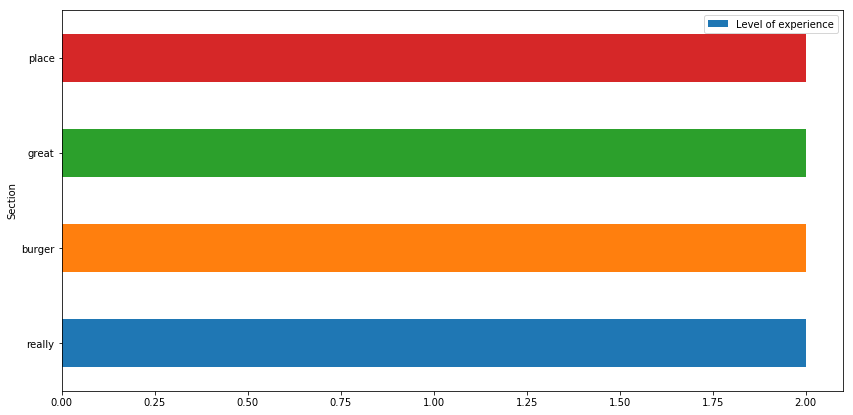

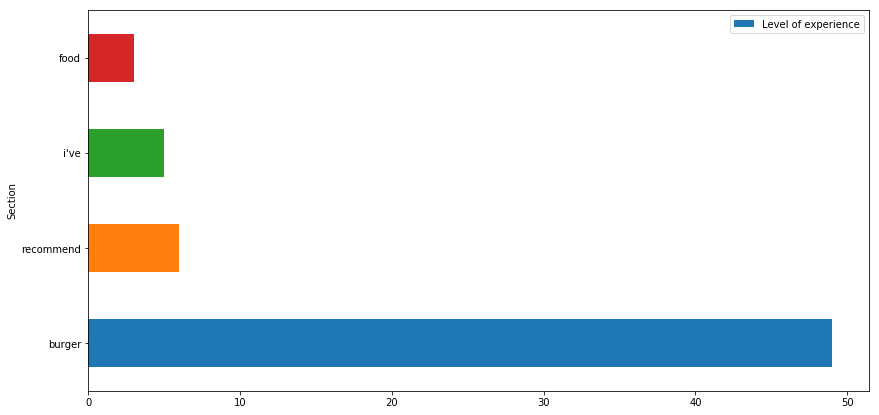

In [18]:
vary_ratings(models, df_loaded, 4, 5, indx=995, bus_name=None)

In [16]:
#3-star and 5-star ratings
models3 = main(df_loaded, 0, 0.25, 3, 5, length=89, state="NV")

Results for NV 
 
 

Number of reviews: 561239 

Confusion matrix
[[101555   7696]
 [  4324  26735]] 

Recall: 95.92%
Precision: 92.96%
Accuracy: 91.43%


In [23]:
# with open("models3.pickle", "wb") as f:
#     pickle.dump(models3, f)

In [12]:
with open("models3.pickle", "rb") as f:
    models3 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 93 

Recall: 96.0%
Precision: 85.71%
Accuracy: 89.25%

 [('burger', array(['ok', 'decent', 'average', 'okay', 'decent', 'average', 'decent'],
      dtype='<U13')), ('sauce', array(['average', 'mediocre'], dtype='<U13')), ('flavor', array(['lacking', 'decent'], dtype='<U13')), ('service', array(['unfortunately', 'decent'], dtype='<U13')), ('turkey', array(['decent', 'worst'], dtype='<U13')), ('onion', array(['ok', 'meh'], dtype='<U13')), ('typical', array(['okay'], dtype='<U13')), ('price', array(['decent'], dtype='<U13')), ('quality', array(['average'], dtype='<U13')), ('hardly', array(['decent'], dtype='<U13')), ('disappoint', array(['overpriced'], dtype='<U13')), ('course', array(['ok'], dtype='<U13')), ('bit', array(['ok'], dtype='<U13')), ('liked', array(['disappointing'], dtype='<U13')), ('would', array(['average'], dtype='<U13'))] 


 [('burger', array(['favorite', 'excellent', 'perfect', 'perfect', 'best', 'great',
       'perfect', 

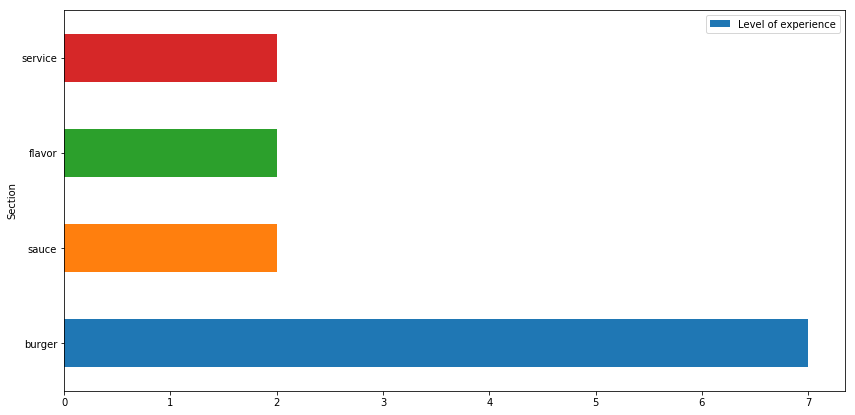

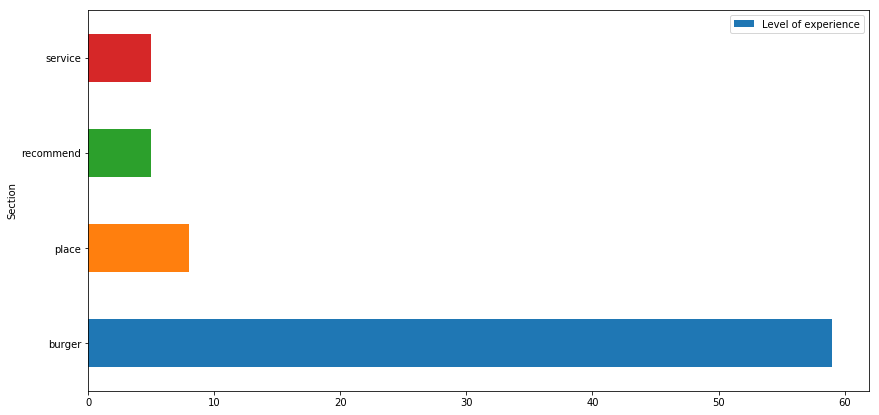

In [13]:
vary_ratings(models3, df_loaded, 3, 5, indx=995, bus_name=None)

In [62]:
#2-star and 5-star ratings
models2 = main(df_loaded, 0, 0.25, 2, 5, length=95, state="NV")

In [25]:
# with open("models2.pickle", "wb") as f:
#     pickle.dump(models2, f)

In [15]:
with open("models2.pickle", "rb") as f:
    models2 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 75 

Recall: 98.0%
Precision: 90.74%
Accuracy: 92.0%

 [('aged', array(['dry', 'dry', 'dry'], dtype='<U13')), ('burger', array(['worst', 'overpriced'], dtype='<U13')), ('better', array(['okay'], dtype='<U13')), ('get', array(['dry'], dtype='<U13')), ('maybe', array(['okay'], dtype='<U13')), ('total', array(['terrible'], dtype='<U13')), ('bad', array(['overpriced'], dtype='<U13')), ('appetizer', array(['unfortunately'], dtype='<U13')), ('nothing', array(['okay'], dtype='<U13')), ('like', array(['ok'], dtype='<U13')), ('juicy', array(['dry'], dtype='<U13')), ('except', array(['dry'], dtype='<U13')), ('three', array(['unfortunately'], dtype='<U13')), ('poor', array(['average'], dtype='<U13')), ('never', array(['bland'], dtype='<U13'))] 


 [('burger', array(['favorite', 'excellent', 'amazing', 'perfect', 'best', 'great',
       'perfect', 'best', 'great', 'best', 'excellent', 'best', 'perfect',
       'perfect', 'perfect', 'great', 'best', 'pe

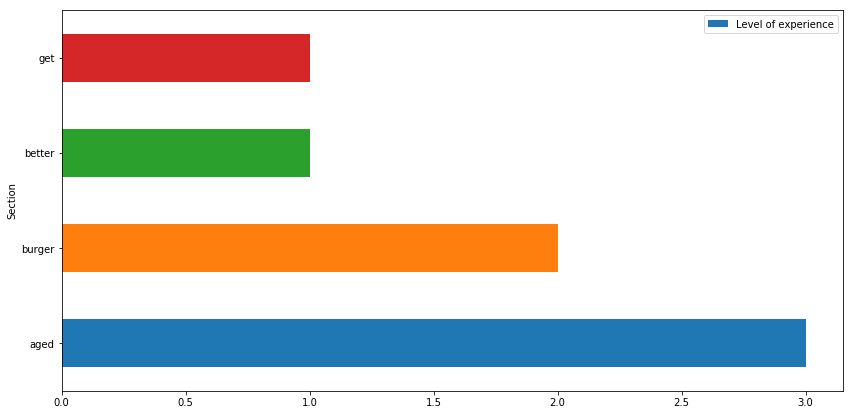

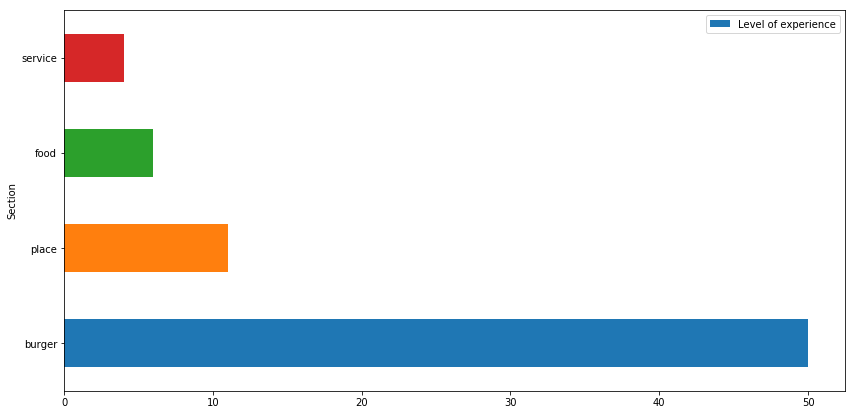

In [16]:
vary_ratings(models2, df_loaded, 2, 5, indx=995, bus_name=None)

In [54]:
#1-star and 5-star ratings
models1 = main(df_loaded, 0, 0.25, 1, 5, length=29, state="NV")

In [26]:
# with open("models1.pickle", "wb") as f:
#     pickle.dump(models1, f)

In [9]:
with open("models1.pickle", "rb") as f:
    models1 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 66 

Recall: 98.0%
Precision: 98.0%
Accuracy: 96.97%

 [('service', array(['worst', 'terrible', 'poor', 'worst', 'worst'], dtype='<U14')), ('experience', array(['awful'], dtype='<U14')), ('wished', array(['disappointment'], dtype='<U14')), ('veggie', array(['disgusting'], dtype='<U14')), ('never', array(['terrible'], dtype='<U14')), ('quality', array(['poor'], dtype='<U14')), ('hamburger', array(['worst'], dtype='<U14')), ('part', array(['worst'], dtype='<U14'))] 


 [('burger', array(['favorite', 'excellent', 'perfect', 'best', 'great', 'perfect',
       'best', 'great', 'best', 'excellent', 'best', 'perfect', 'perfect',
       'perfect', 'great', 'best', 'great', 'loved', 'love', 'excellent',
       'amazing', 'excellent', 'favorite', 'great', 'best', 'perfect',
       'best', 'perfect', 'awesome', 'great', 'perfect', 'best', 'best',
       'best', 'best', 'best', 'amazing', 'great', 'best', 'fantastic'],
      dtype='<U10')), ('place', a

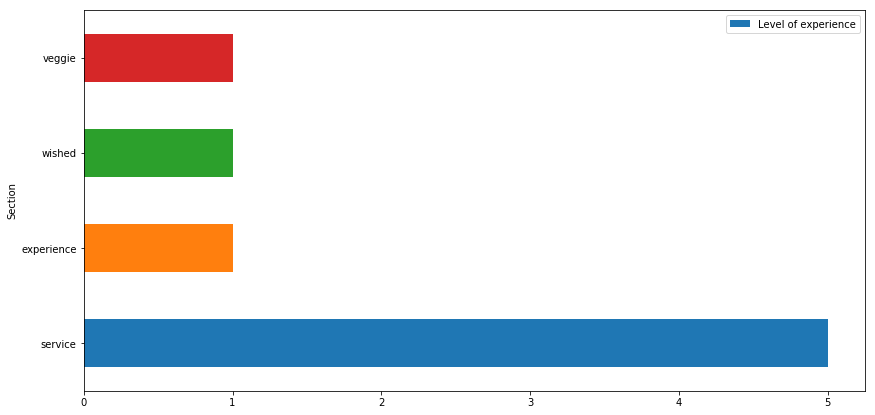

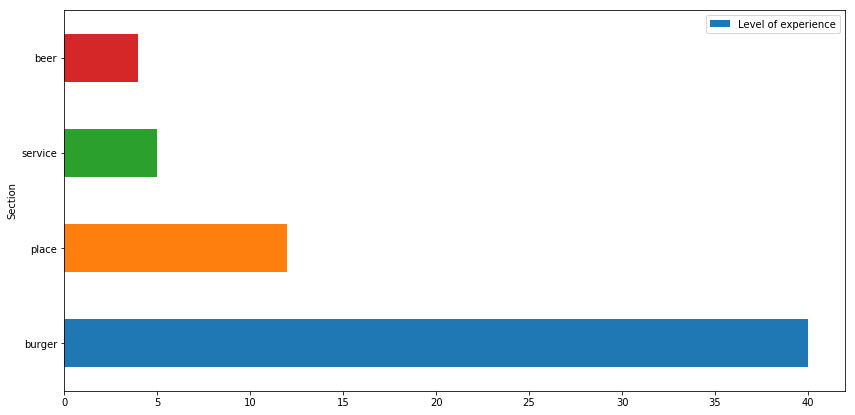

In [17]:
vary_ratings(models1, df_loaded, 1, 5, indx=995, bus_name=None)

In [20]:
#4-star and 5-star ratings
models22 = main(df_loaded, 0, 0.25, 1, 2, length=89, state="NV")

Results for NV 
 
 

Number of reviews: 215647 

Confusion matrix
[[16675  6084]
 [ 7211 23942]] 

Recall: 69.81%
Precision: 73.27%
Accuracy: 75.34%


In [22]:
# with open("../efs/models/models22.pickle", "wb") as f:
#     pickle.dump(models22, f)

In [24]:
with open("../efs/models/models22.pickle", "rb") as f:
    models22 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 41 

Recall: 84.0%
Precision: 91.3%
Accuracy: 85.37%

 [('service', array(['worst', 'terrible', 'worst', 'worst'], dtype='<U10')), ('experience', array(['awful'], dtype='<U10')), ('burger', array(['worst'], dtype='<U10')), ('total', array(['terrible'], dtype='<U10')), ('veggie', array(['disgusting'], dtype='<U10')), ('never', array(['terrible'], dtype='<U10')), ('anytime', array(['negative'], dtype='<U10')), ('hamburger', array(['worst'], dtype='<U10')), ('part', array(['worst'], dtype='<U10'))] 


 [('burger', array(['great', 'good', 'good', 'great', 'good', 'great', 'great',
       'decent', 'good', 'good', 'good'], dtype='<U9')), ('service', array(['good', 'good', 'decent', 'good'], dtype='<U9')), ('nothing', array(['okay', 'alright', 'ok', 'okay'], dtype='<U9')), ('tell', array(['nice', 'delicious', 'good'], dtype='<U9')), ('good', array(['good', 'nice', 'good'], dtype='<U9')), ('enough', array(['nice', 'good', 'decent'], dtype='<U9')),

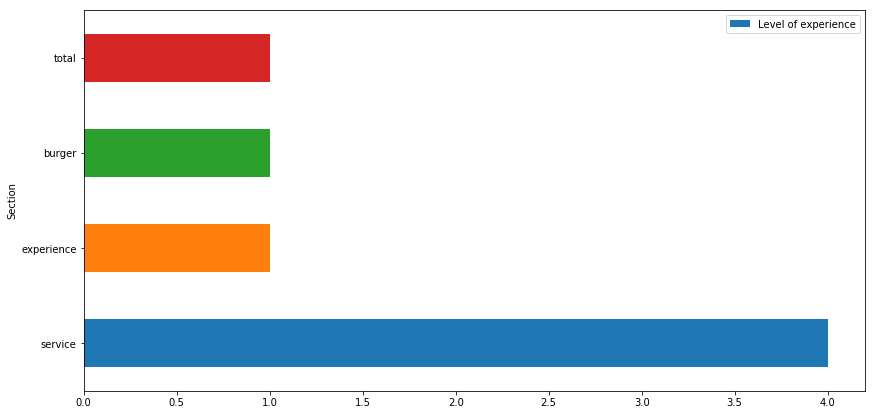

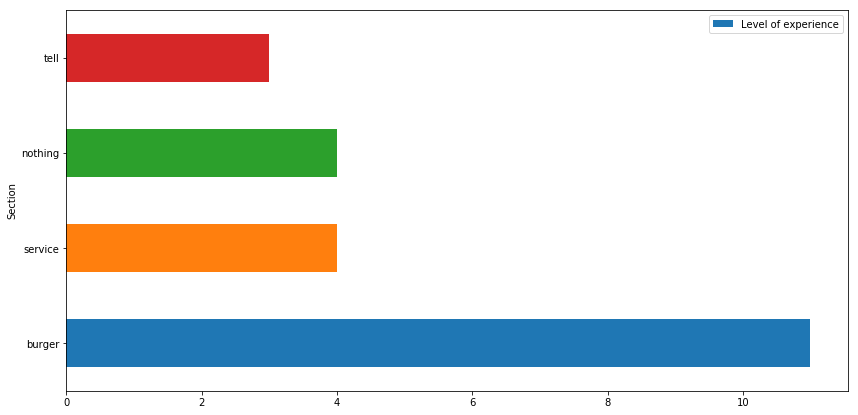

In [25]:
vary_ratings(models22, df_loaded, 1, 2, indx=995, bus_name=None)

In [28]:
#3-star and 5-star ratings
models13 = main(df_loaded, 0, 0.25, 1, 3, length=89, state="NV")

Results for NV 
 
 

Number of reviews: 258358 

Confusion matrix
[[31070  3653]
 [ 3560 26307]] 

Recall: 89.72%
Precision: 89.48%
Accuracy: 88.83%


In [29]:
# with open("../efs/models/models13.pickle", "wb") as f:
#     pickle.dump(models13, f)

In [30]:
with open("../efs/models/models13.pickle", "rb") as f:
    models13 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 59 

Recall: 0.98%
Precision: 0.95%
Accuracy: 94.92%

 [('service', array(['worst', 'terrible', 'poor', 'worst', 'worst'], dtype='<U14')), ('experience', array(['awful'], dtype='<U14')), ('great', array(['awful'], dtype='<U14')), ('side', array(['tasteless'], dtype='<U14')), ('turkey', array(['worst'], dtype='<U14')), ('found', array(['awful'], dtype='<U14')), ('veggie', array(['disgusting'], dtype='<U14')), ('never', array(['terrible'], dtype='<U14')), ('quality', array(['poor'], dtype='<U14')), ('ordered', array(['horrible'], dtype='<U14')), ("i'm", array(['worse'], dtype='<U14')), ('line', array(['waste'], dtype='<U14')), ('hamburger', array(['worst'], dtype='<U14')), ('beef', array(['gross'], dtype='<U14')), ('part', array(['worst'], dtype='<U14'))] 


 [('burger', array(['perfect', 'perfect', 'good', 'good', 'great', 'great', 'good',
       'delicious', 'decent', 'perfect', 'perfect', 'perfect', 'great',
       'perfect', 'yummy', 'per

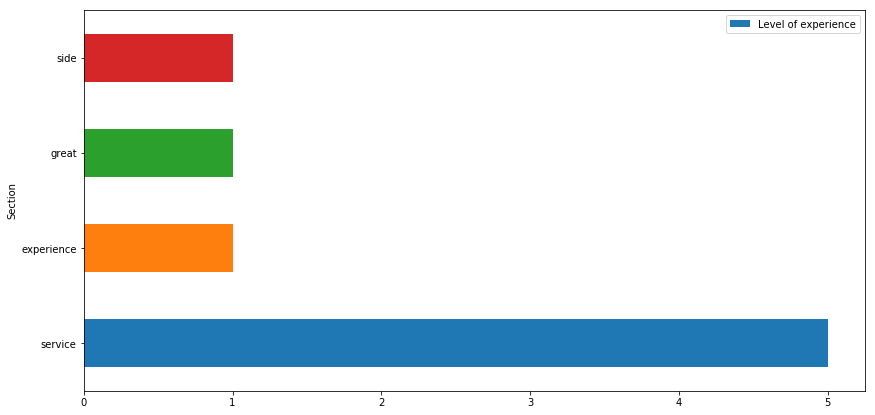

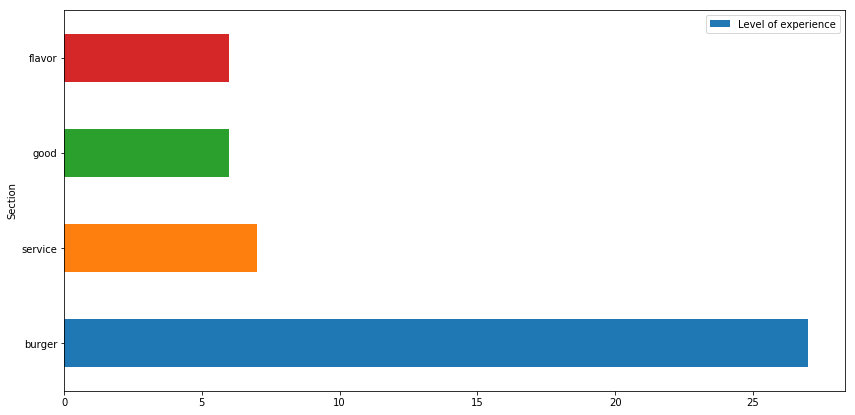

In [31]:
vary_ratings(models13, df_loaded, 1, 3, indx=995, bus_name=None)

In [49]:
#2-star and 5-star ratings
models14 = main(df_loaded, 0, 0.25, 1, 4, length=95, state="NV")

Results for NV 
 
 

Number of reviews: 385001 

Confusion matrix
[[64712  2164]
 [ 1603 27772]] 

Recall: 97.58%
Precision: 96.76%
Accuracy: 96.09%


In [46]:
# with open("../efs/models/models14.pickle", "wb") as f:
#     pickle.dump(models14, f)

In [47]:
with open("../efs/models/models14.pickle", "rb") as f:
    models14 = pickle.load(f)

Restaurant Name: LBS Burger 

Size of corpus: 103 

Recall: 0.99%
Precision: 0.97%
Accuracy: 96.12%

 [('service', array(['worst', 'terrible', 'poor', 'worst', 'worst'], dtype='<U14')), ('way', array(['disappointed'], dtype='<U14')), ('experience', array(['awful'], dtype='<U14')), ('interesting', array(['disappointed'], dtype='<U14')), ('veggie', array(['disgusting'], dtype='<U14')), ('never', array(['terrible'], dtype='<U14')), ('booth', array(['terrible'], dtype='<U14')), ('quality', array(['poor'], dtype='<U14')), ('execution', array(['disappointed'], dtype='<U14')), ('manager', array(['horrible'], dtype='<U14')), ('hamburger', array(['worst'], dtype='<U14')), ('part', array(['worst'], dtype='<U14')), ('one', array(['horrible'], dtype='<U14'))] 


 [('burger', array(['perfect', 'perfect', 'yummy', 'perfect', 'perfect', 'good',
       'perfect', 'perfect', 'excellent', 'good', 'good', 'perfect',
       'perfect', 'perfect', 'great', 'perfect', 'good', 'perfect',
       'good', 'tasty

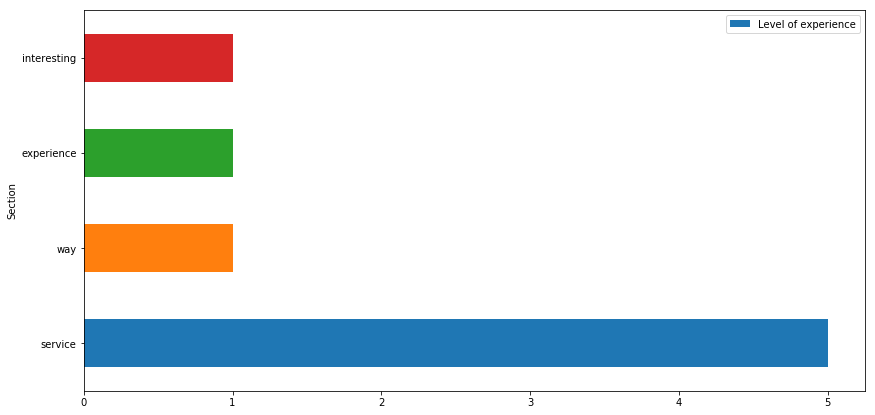

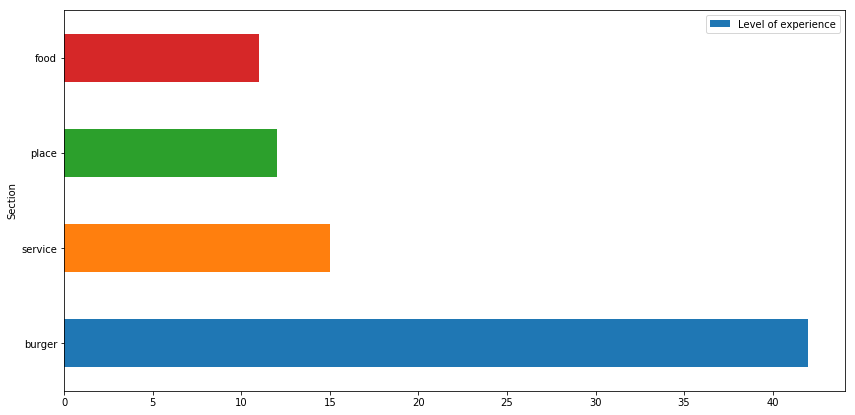

In [48]:
util.vary_ratings(models14, df_loaded, 1, 4, indx=995, bus_name=None)

In [4]:
df_loaded[(df_loaded["bus_name"]=="LBS Burger") & (df_loaded["stars_rev"]==3)][["text","stars_rev"]].iloc[1,0]

"Devoted to the ground round, LBS serves half-pound 21-day dry aged Organic Hereford New York/Sirloin patties with solid beef flavor. A little saltier and chewier than other gourmet burgers I've tried, and plenty sloppy, they do come on nice soft egg buns with several cheese options (goat, brie, pepperjack, gruyere) and other good add-ons like smoked bacon.\n\nIn all honesty, those who think this place is awesome...need to try some of the other burgers in the same price range in town (though there's nothing else on this level in Summerlin, of which I'm aware anyhow)"